In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, fnmatch

import scipy
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fftshift,dct
from scipy import interpolate

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
scaler = Normalizer(norm='max')

import torch
from hmmlearn import hmm
import re
import random

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

1. лоу пасс                        
2. попробовать рекуррентной и понять
3. попробовать сверточной           
        Github
4. <b>попробовать марковскими цепями</b>
           Разделить выборку на n групп по лейблам, и обучить n моделей. Тестовую выборку скармливать каждой модели, они должны какую то оценку выдавать и по этой оценке решать к какому классу принадлежит
5. <b>Сбалансировать классы</b>
7. попробовать разбить по амплитуде на циклы сердцебиения, и для каждого предсказывать вероятность, потому там подумать как их перемножить чи шо
8. <b>минимизация ошибки второго рода, пропуска цели, FN</b> 
9. попробовать с артифакт и без extra 
10. попробовать без фильтрации
11. <b>аугментация</b>

# Frequency Analysis

In [3]:
coefs = []
path = 'D:/Учеба/Технопарк/Heart/'
A_folder_filt = path+'set_filt_1/'
# A_folder_filt = path+'set_1/'

i=0
scaler = Normalizer(norm='max')
for fil in os.listdir(A_folder_filt):
    fs, data = wavfile.read(A_folder_filt+fil)
#     data = data[:120000]
    f, t, P = signal.spectrogram(data, fs,window='hamming',nperseg=500,noverlap=250)
    N = P.shape[1]
    
    #-----------------------------------------------------------------------------
    # Calculating a block of triangle mel-filters
    nfilt=40
    low_freq_mel = 0
    NFFT = len(f)
    high_freq_mel = (2595 * np.log10(1 + (fs / 2) / 700))  
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  
    hz_points = (700 * (10**(mel_points / 2595) - 1))  
    bin = np.round(2 * NFFT * hz_points / fs)

    fbank = np.zeros((nfilt, int(np.floor(NFFT))))

    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])       
    #------------------------------------------------------------------------------
    filter_banks = np.dot(fbank,P)  
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks) 
    filter_banks = filter_banks - (np.mean(filter_banks, axis=1).reshape(-1,1) + 1e-8)
    num_ceps = 14
    mfc = filter_banks[1 : (num_ceps + 1),:] # select ony 14 first coeffs
    
    # Interpolationg to get coefficient matrix of certain shape
    std_len = 512 # "time" lenght,m in n*m matrix
    
    x = np.arange(0,mfc.shape[1],1)
    y = np.arange(0,mfc.shape[0],1)
    f = interpolate.interp2d(x, y, mfc, kind='cubic')
    xnew = np.arange(0,mfc.shape[1],mfc.shape[1]/std_len)
    mfc_interp = f(xnew, y)
    
    # scaling to (0,1)
    mfc_interp = scaler.fit_transform(mfc_interp)
    
    if i==0:
        coefs = torch.FloatTensor(mfc_interp).unsqueeze(0)
    else:
        coefs = torch.cat((coefs,torch.FloatTensor(mfc_interp).unsqueeze(0)))
    i+=1
    
labels = []
for i in os.listdir(A_folder_filt):
    if i[0]=='n':
        labels.append(0)
    elif i[0]=='m':
        labels.append(1)
#     elif i[0]=='e':
#         labels.append(2)
    else:
        labels.append(2)

# print(i)
labels = torch.FloatTensor(np.array(labels).reshape(-1,1))

# A bit of data augmentation

In [2]:
def mel_ceps(data, fs, std_len=512): 
    f, t, P = signal.spectrogram(data, fs, window='hamming',nperseg=500,noverlap=250)
    N = P.shape[1]

    #-----------------------------------------------------------------------------
    # Calculating a block of triangle mel-filters
    nfilt=40
    low_freq_mel = 0
    NFFT = len(f)
    high_freq_mel = (2595 * np.log10(1 + (fs / 2) / 700))  
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  
    hz_points = (700 * (10**(mel_points / 2595) - 1))  
    bin = np.round(2 * NFFT * hz_points / fs)

    fbank = np.zeros((nfilt, int(np.floor(NFFT))))

    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])       
    #------------------------------------------------------------------------------
    filter_banks = np.dot(fbank,P)  
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks) 
    filter_banks = filter_banks - (np.mean(filter_banks, axis=1).reshape(-1,1) + 1e-8)
    num_ceps = 14
    mfc = filter_banks[1 : (num_ceps + 1),:] # select ony 14 first coeffs

    x = np.arange(0,mfc.shape[1],1)
    y = np.arange(0,mfc.shape[0],1)
    f = interpolate.interp2d(x, y, mfc, kind='cubic')
    xnew = np.arange(0,mfc.shape[1],mfc.shape[1]/std_len)
    mfc_interp = f(xnew, y)
    
    return mfc_interp

In [3]:
coefs = []
labels = []
path = 'D:/Учеба/Технопарк/Heart/'
A_folder_filt = path+'set_filt_2/'
# A_folder_filt = path+'set_1/'

i=True
scaler = Normalizer(norm='max')
for fil in os.listdir(A_folder_filt):
    fs, data_in = wavfile.read(A_folder_filt+fil)
    data = data_in[:120000]
    
    #original wav
    mfc_interp = mel_ceps(data, fs)
    if i:
        coefs = torch.FloatTensor(mfc_interp).unsqueeze(0)
        i=False
    else:
        coefs = torch.cat((coefs,torch.FloatTensor(mfc_interp).unsqueeze(0)))

    # noised 
    noise_power = data.max() - data.mean()
    data = data + np.random.normal(scale=np.sqrt(noise_power), size=data.shape)
    mfc_interp = mel_ceps(data, fs)
    
    coefs = torch.cat((coefs,torch.FloatTensor(mfc_interp).unsqueeze(0)))
    
    # other part of initial signal
    data = data_in[:160000]
    mfc_interp = mel_ceps(data, fs)
    
    coefs = torch.cat((coefs,torch.FloatTensor(mfc_interp).unsqueeze(0)))

    # other part of initial signal
    data = data_in[:80000]
    mfc_interp = mel_ceps(data, fs)
    
    coefs = torch.cat((coefs,torch.FloatTensor(mfc_interp).unsqueeze(0)))
    
    if fil[0]=='n':
        labels.append(0)
        labels.append(0)
        labels.append(0)
        labels.append(0)
    elif fil[0]=='m':
        labels.append(1)
        labels.append(1)
        labels.append(1)
        labels.append(1)
    elif fil[0]=='e':
        labels.append(2)
        labels.append(2)
        labels.append(2)
        labels.append(2)
    else:
        labels.append(3)
        labels.append(3)
        labels.append(3)
        labels.append(3)
    
labels = torch.FloatTensor(np.array(labels).reshape(-1,1))

# CONV

In [4]:
r=torch.randperm(coefs.shape[0]) #шафлим
X = coefs[r]
y = labels.reshape(1,-1)[0][r]

In [5]:
from sklearn.model_selection import train_test_split
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [7]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()
X_val = X_val.unsqueeze(1).float()

In [8]:
X_train.shape

torch.Size([1875, 1, 14, 512])

In [9]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=3.0e-4)
    
    batch_size = 20

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(100):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)
            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            
            X_batch

        net.eval()
        test_preds = net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)

        print(accuracy)
#     del net
    return test_accuracy_history, test_loss_history

accuracies = {}
losses = {}

In [10]:
class HeartNet_Conv(torch.nn.Module):
    def __init__(self,ch = [16,32,64,128]):
        super(HeartNet_Conv, self).__init__()
        
        self.conv1a = torch.nn.Conv2d(1, ch[0], (3,13),padding = 1)
        self.bn1a   = torch.nn.BatchNorm2d(num_features=ch[0])
        self.act1a  = torch.nn.ReLU()
        self.conv1b = torch.nn.Conv2d(ch[0], ch[0], (3,13),padding = 1)
        self.bn1b   = torch.nn.BatchNorm2d(num_features=ch[0])
        self.act1b  = torch.nn.ReLU()
        # 14*1260   (-20 - 14*492)  
        self.pool1 = torch.nn.MaxPool2d((1,3), stride=(1,3))
        # 7*630*10    (/3 - 14*164)   

        self.conv2a = torch.nn.Conv2d(ch[0], ch[1], (3,13),padding = 1)
        self.bn2a   = torch.nn.BatchNorm2d(num_features=ch[1])
        self.act2a  = torch.nn.ReLU()
        self.conv2b = torch.nn.Conv2d(ch[1], ch[1], (3,13),padding = 1)
        self.bn2b   = torch.nn.BatchNorm2d(num_features=ch[1])
        self.act2b  = torch.nn.ReLU()
        # 14*1260   (-20 - 14*144)  
        self.pool2 = torch.nn.MaxPool2d((1,3), stride=(1,3))
        # 7*630*10    (/3 - 14*48)

        self.conv3a = torch.nn.Conv2d(ch[1], ch[2], (3,13),padding = 1)
        self.bn3a   = torch.nn.BatchNorm2d(num_features=ch[2])
        self.act3a  = torch.nn.ReLU()
        self.conv3b = torch.nn.Conv2d(ch[2], ch[2], (3,13),padding = 1)
        self.bn3b   = torch.nn.BatchNorm2d(num_features=ch[2])
        self.act3b  = torch.nn.ReLU()
        # 14*1260   (-20 - 14*28)  
        self.pool3 = torch.nn.MaxPool2d((2,2), stride=(2,2))
        # 7*630*10    (/2 - 7*14)
        
        self.conv4 = torch.nn.Conv2d(ch[2], ch[3], (4,7),padding = 1)
        self.bn4   = torch.nn.BatchNorm2d(num_features=ch[3])
        self.act4  = torch.nn.ReLU()
        #            (-4 - 6*10)
        self.pool4 = torch.nn.MaxPool2d((2,2), stride=(2,2))
        #            (/2 - 3*5)
        
        self.fc1   = torch.nn.Linear(3 * 5 * ch[3],200)
        self.act5  = torch.nn.ReLU()
        
        self.fc2   = torch.nn.Linear(200, 4)
    
    def forward(self, x):
        
        x = self.conv1a(x)
        x = self.bn1a(x)
        x = self.act1a(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.act1b(x)
        x = self.pool1(x)
        
        x = self.conv2a(x)
        x = self.bn2a(x)
        x = self.act2a(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.act2b(x)
        x = self.pool2(x)
        
        x = self.conv3a(x)
        x = self.bn3a(x)
        x = self.act3a(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.act3b(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.act4(x)
        
        x = self.pool4(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act5(x)
        
        x = self.fc2(x)
  
        return x

In [12]:
model_parameters = filter(lambda p: p.requires_grad, HeartNet_Conv().parameters())
sum([np.prod(p.size()) for p in model_parameters])

925564

In [11]:
model = HeartNet_Conv()
accuracies['cifar_net_80_no'], losses['cifar_net_80_no'] = \
    train(model, X_train, y_train, X_test, y_test)

tensor(0.6838)
tensor(0.7650)
tensor(0.6966)
tensor(0.8248)
tensor(0.8675)
tensor(0.8889)
tensor(0.8547)
tensor(0.8504)
tensor(0.8504)
tensor(0.8889)
tensor(0.9103)
tensor(0.9145)
tensor(0.9103)
tensor(0.9145)
tensor(0.9188)
tensor(0.9145)
tensor(0.9188)
tensor(0.9145)
tensor(0.9231)
tensor(0.9145)
tensor(0.9231)
tensor(0.9188)
tensor(0.9231)
tensor(0.9188)
tensor(0.9188)
tensor(0.9188)
tensor(0.9188)
tensor(0.9145)
tensor(0.9188)
tensor(0.9188)
tensor(0.9145)
tensor(0.9188)
tensor(0.9188)
tensor(0.9231)
tensor(0.9231)
tensor(0.9145)
tensor(0.9231)
tensor(0.9231)
tensor(0.9188)
tensor(0.9231)
tensor(0.9274)
tensor(0.9231)
tensor(0.9231)
tensor(0.9231)
tensor(0.9145)
tensor(0.9188)
tensor(0.9188)
tensor(0.9188)
tensor(0.9188)
tensor(0.9188)
tensor(0.9188)
tensor(0.9231)
tensor(0.9188)
tensor(0.9145)
tensor(0.9316)
tensor(0.9188)
tensor(0.6026)
tensor(0.7821)
tensor(0.8632)
tensor(0.8846)
tensor(0.9316)
tensor(0.9188)
tensor(0.9060)
tensor(0.9060)
tensor(0.9060)
tensor(0.9274)
tensor(0.9

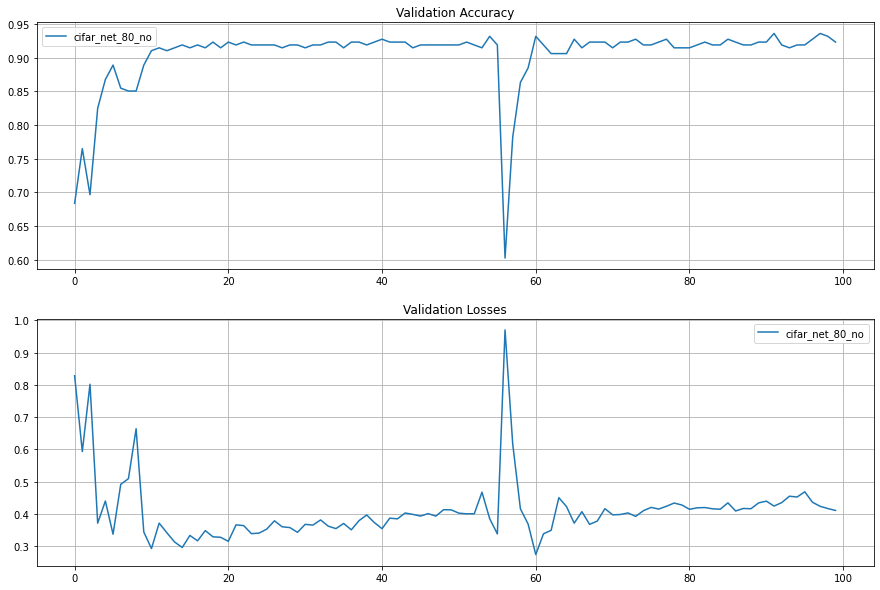

In [13]:
fig,(ax,bx) = plt.subplots(2,figsize=(15,10))
for experiment_id in accuracies.keys():
    ax.plot(accuracies[experiment_id], label=experiment_id)
    ax.legend()
    ax.set_title('Validation Accuracy');
ax.grid()
for experiment_id in accuracies.keys():
    bx.plot(losses[experiment_id], label=experiment_id)
    bx.legend()
    bx.set_title('Validation Losses');
bx.grid()

In [51]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
y_pred = model.forward(X_val.to(device)).argmax(dim=1)
(y_pred.cpu() == y_val).float().mean().data

tensor(0.9245)

In [53]:
y_pred

tensor([0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 2], device='cuda:0')

In [52]:
y_val

tensor([0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 2])

In [358]:
recall_score(y_test.cpu().numpy(),y_pred.cpu(),average='macro')

0.7792592592592592

In [81]:
#save
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in heart_net_conv.state_dict():
    print(param_tensor, "\t", heart_net_conv.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([10, 1, 3, 23])
conv1.bias 	 torch.Size([10])
conv2.weight 	 torch.Size([15, 10, 2, 11])
conv2.bias 	 torch.Size([15])
conv3.weight 	 torch.Size([20, 15, 3, 11])
conv3.bias 	 torch.Size([20])
fc1.weight 	 torch.Size([100, 2160])
fc1.bias 	 torch.Size([100])
fc2.weight 	 torch.Size([20, 100])
fc2.bias 	 torch.Size([20])
fc3.weight 	 torch.Size([4, 20])
fc3.bias 	 torch.Size([4])


In [82]:
# Specify a path
PATH = "D:/Учеба/Технопарк/Heart/models/conv_nma_512.pt"

# Save
torch.save(heart_net_conv.state_dict(), PATH)

# Load
# lenet5.load_state_dict(torch.load(PATH))
# lenet5.eval()

# HMM

In [82]:
# Итак. Берем датасет мел кепстральных кэфов, выбираем оттуда только один два и три. Создаем модель, обучаем ее на 10 записях.
# Создаем еще две, и их обучаем. Оставшиеся 3 пары тестим и смотрим на какой модели больше вероятность.

#...fit(X)
# X - Датасет по сути. Строки это фреймы, столбцы это фичи, то есть у нас будет 14-мерное признаковое пространство, и фазовая
# траектория будет двигаться с течением времени. Единственная проблема - то, что начало слова/сердцебиения будет всегда в разное
# время. Посему, остро стоит вопрос правильного определения начала

# вроде че то работает, но надо проверить на жигулевском датасете

# Видимо, для обучения у последовательностей не обязательно одинаковые длины!!!

In [21]:
data = torch.load('D:/rech/VeriRu/words/dataset_conv_cepstr_96.pt')
labels = torch.load('D:/rech/VeriRu/words/dataset_labels_cepstr_96.pt')

In [22]:
X =data.numpy()
y = labels.squeeze(dim=1).numpy()

In [23]:
X0 = X[np.where(y==0)]
X1 = X[np.where(y==1)]
X2 = X[np.where(y==2)]
X3 = X[np.where(y==3)]
X4 = X[np.where(y==4)]
X5 = X[np.where(y==5)]
X6 = X[np.where(y==6)]
X7 = X[np.where(y==7)]
X8 = X[np.where(y==8)]
X9 = X[np.where(y==9)]

In [24]:
X0_train, X0_test = train_test_split(X0, test_size = 0.2)
shape0 = [X0_train.shape[2],X0_train.shape[0]]

X1_train, X1_test = train_test_split(X1, test_size = 0.2)
shape1 = [X1_train.shape[2],X1_train.shape[0]]

X2_train, X2_test = train_test_split(X2, test_size = 0.2)
shape2 = [X2_train.shape[2],X2_train.shape[0]]

X3_train, X3_test = train_test_split(X3, test_size = 0.2)
shape3 = [X3_train.shape[2],X3_train.shape[0]]

X4_train, X4_test = train_test_split(X4, test_size = 0.2)
shape4 = [X4_train.shape[2],X4_train.shape[0]]

X5_train, X5_test = train_test_split(X5, test_size = 0.2)
shape5 = [X5_train.shape[2],X5_train.shape[0]]

X6_train, X6_test = train_test_split(X6, test_size = 0.2)
shape6 = [X6_train.shape[2],X6_train.shape[0]]

X7_train, X7_test = train_test_split(X7, test_size = 0.2)
shape7 = [X7_train.shape[2],X7_train.shape[0]]

X8_train, X8_test = train_test_split(X8, test_size = 0.2)
shape8 = [X8_train.shape[2],X8_train.shape[0]]

X9_train, X9_test = train_test_split(X9, test_size = 0.2)
shape9 = [X9_train.shape[2],X9_train.shape[0]]

In [25]:
model0 = hmm.GaussianHMM(n_components=12, covariance_type="full",n_iter=100)
model1 = hmm.GaussianHMM(n_components=12, covariance_type="full",n_iter=100)
model2 = hmm.GaussianHMM(n_components=12, covariance_type="full",n_iter=100)
model3 = hmm.GaussianHMM(n_components=12, covariance_type="full",n_iter=100)
model4 = hmm.GaussianHMM(n_components=12, covariance_type="full",n_iter=100)
model5 = hmm.GaussianHMM(n_components=12, covariance_type="full",n_iter=100)
model6 = hmm.GaussianHMM(n_components=12, covariance_type="full",n_iter=100)
model7 = hmm.GaussianHMM(n_components=12, covariance_type="full",n_iter=100)
model8 = hmm.GaussianHMM(n_components=12, covariance_type="full",n_iter=100)
model9 = hmm.GaussianHMM(n_components=12, covariance_type="full",n_iter=100)

In [26]:
# Транспонируем матрицы как надо для СММ
X0_train = X0_train.transpose(0,2,1).reshape(-1,X0_train.shape[1]) # (обучающие_выборки*фреймы , фичи)
X1_train = X1_train.transpose(0,2,1).reshape(-1,X1_train.shape[1]) 
X2_train = X2_train.transpose(0,2,1).reshape(-1,X2_train.shape[1]) 
X3_train = X3_train.transpose(0,2,1).reshape(-1,X3_train.shape[1]) 
X4_train = X4_train.transpose(0,2,1).reshape(-1,X4_train.shape[1]) 
X5_train = X5_train.transpose(0,2,1).reshape(-1,X5_train.shape[1]) 
X6_train = X6_train.transpose(0,2,1).reshape(-1,X6_train.shape[1]) 
X7_train = X7_train.transpose(0,2,1).reshape(-1,X7_train.shape[1])
X8_train = X8_train.transpose(0,2,1).reshape(-1,X8_train.shape[1]) 
X9_train = X9_train.transpose(0,2,1).reshape(-1,X9_train.shape[1]) 

# Длины последовательностей - [длина фреймов]*количество последоваетльностей, так как тут фреймы одной длины
length0 =[shape0[0]]*shape0[1]
length1 =[shape1[0]]*shape1[1]
length2 =[shape2[0]]*shape2[1]
length3 =[shape3[0]]*shape3[1]
length4 =[shape4[0]]*shape4[1]
length5 =[shape5[0]]*shape5[1]
length6 =[shape6[0]]*shape6[1]
length7 =[shape7[0]]*shape7[1]
length8 =[shape8[0]]*shape8[1]
length9 =[shape9[0]]*shape9[1]

In [27]:
model0.fit(X0_train,length0),
print(0),

model1.fit(X1_train,length1),
print(1),

model2.fit(X2_train,length2),
print(2),

model3.fit(X3_train,length3),
print(3),

model4.fit(X4_train,length4),
print(4),

model5.fit(X5_train,length5),
print(5),

model6.fit(X6_train,length6),
print(6),

model7.fit(X7_train,length7),
print(7),

model8.fit(X8_train,length8),
print(8),

model9.fit(X9_train,length9),
print(9)

0
1
2
3
4
5
6
7
8
9


TypeError: __init__() got multiple values for argument 'file'

In [37]:
S = np.zeros(10)
n = 200
for i in range(n):
    S[0] = S[0] + model0.score(X0_test[i].T)
    S[1] = S[1] + model0.score(X1_test[i].T)
    S[2] = S[2] + model0.score(X2_test[i].T)
    S[3] = S[3] + model0.score(X3_test[i].T)
    S[4] = S[4] + model0.score(X4_test[i].T)
    S[5] = S[5] + model0.score(X5_test[i].T)
    S[6] = S[6] + model0.score(X6_test[i].T)
    S[7] = S[7] + model0.score(X7_test[i].T)
    S[8] = S[8] + model0.score(X8_test[i].T)
    S[9] = S[9] + model0.score(X9_test[i].T)
print('0 score:',S[0] / n,
      '\n 1 score:',S[1] / n,
      '\n 2 score:',S[2] / n,
      '\n 3 score:',S[3] / n,
      '\n 4 score:',S[4] / n,
      '\n 5 score:',S[5] / n,
      '\n 6 score:',S[6] / n,
      '\n 7 score:',S[7] / n,
      '\n 8 score:',S[8] / n,
      '\n 9 score:',S[9] / n)

Exception ignored in: <function tqdm.__del__ at 0x000002559BC1CC18>
Traceback (most recent call last):
  File "D:\Progi\Anaconda\lib\site-packages\tqdm\std.py", line 1124, in __del__
    self.close()
  File "D:\Progi\Anaconda\lib\site-packages\tqdm\notebook.py", line 267, in close
    super(tqdm_notebook, self).close(*args, **kwargs)
  File "D:\Progi\Anaconda\lib\site-packages\tqdm\std.py", line 1306, in close
    if self.disable:
AttributeError: 'tqdm_notebook' object has no attribute 'disable'


0 score: -4405.418626216825 
 1 score: -4643.930653584556 
 2 score: -4583.746014216346 
 3 score: -4590.945948170596 
 4 score: -4712.396580437856 
 5 score: -4671.2361598895695 
 6 score: -4817.48493188922 
 7 score: -4581.182178289438 
 8 score: -4538.282686437117 
 9 score: -4620.5932540264375


In [56]:
S = np.zeros((10,200))
n = 200
for i in range(n):
    S[0,i] = model0.score(X0_test[i].T)
    S[1,i] = model0.score(X1_test[i].T)
    S[2,i] = model0.score(X2_test[i].T)
    S[3,i] = model0.score(X3_test[i].T)
    S[4,i] = model0.score(X4_test[i].T)
    S[5,i] = model0.score(X5_test[i].T)
    S[6,i] = model0.score(X6_test[i].T)
    S[7,i] = model0.score(X7_test[i].T)
    S[8,i] = model0.score(X8_test[i].T)
    S[9,i] = model0.score(X9_test[i].T)
print('0 score:',S[0].max(),
      '\n 1 score:',S[1].min(),
      '\n 2 score:',S[2].min(),
      '\n 3 score:',S[3].min(),
      '\n 4 score:',S[4].min(),
      '\n 5 score:',S[5].min(),
      '\n 6 score:',S[6].min(),
      '\n 7 score:',S[7].min(),
      '\n 8 score:',S[8].min(),
      '\n 9 score:',S[9].min())

0 score: -4053.6711788240577 
 1 score: -5233.519843116692 
 2 score: -5095.626918841528 
 3 score: -4886.262462603151 
 4 score: -5179.940290229123 
 5 score: -5285.0868089913565 
 6 score: -5426.792180607477 
 7 score: -5029.698223254798 
 8 score: -4916.1423450013435 
 9 score: -5073.756169691856


# Тест

In [177]:
data = torch.load('D:/rech/datasets/voice_numbers_conv_mel.pt')
labels = torch.load('D:/rech/conv_labels.pt')

In [178]:
from hmmlearn import hmm
X =data[:36].numpy()
y = labels[:36].numpy()

In [179]:
X1 = X[:12]
y1 = y[:12]
X2 = X[12:24]
y2 = y[12:24]
X3 = X[24:36]
y3 = y[24:36]

In [180]:
X1[9:].shape

(3, 14, 90)

In [181]:
# X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2)
# X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2)
# X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.2)
# n=12

X1_train = X1[:9]
X1_test  = X1[9:]

X2_train = X2[:9]
X2_test  = X2[9:]

X3_train = X3[:9]
X3_test  = X3[9:]
n=3

In [182]:
np.random.seed(42)

model1 = hmm.GaussianHMM(n_components=10, covariance_type="full",n_iter=100)
model2 = hmm.GaussianHMM(n_components=10, covariance_type="full",n_iter=100)
model3 = hmm.GaussianHMM(n_components=10, covariance_type="full",n_iter=100)

In [183]:
# Транспонируем матрицы как надо для СММ
X1_train = X1_train.transpose(0,2,1).reshape(-1,X1_train.shape[1]) # (обучающие_выборки*фреймы , фичи)
X2_train = X2_train.transpose(0,2,1).reshape(-1,X2_train.shape[1]) # (обучающие_выборки*фреймы , фичи)
X3_train = X3_train.transpose(0,2,1).reshape(-1,X3_train.shape[1]) # (обучающие_выборки*фреймы , фичи)

length =[90]*9

In [184]:
# Транспонируем матрицы как надо для СММ
# X1_train = X1_train.reshape(-1,X1_train.shape[2]).T # (обучающие_выборки*фреймы , фичи)
# X2_train = X2_train.reshape(-1,X2_train.shape[2]).T # (обучающие_выборки*фреймы , фичи)
# X3_train = X3_train.reshape(-1,X3_train.shape[2]).T # (обучающие_выборки*фреймы , фичи)

# length =[14]*9

In [174]:
X1_train.shape

(90, 126)

In [186]:
model1.fit(X1_train,length)
model2.fit(X2_train,length)
model3.fit(X3_train,length)

Fitting a model with 81369 free scalar parameters with only 11340 data points will result in a degenerate solution.


ValueError: more than 90 samples in lengths array [[14], [14], [14], [14], [14], [14], [14], [14], [14]]

In [95]:
X1_train.shape

(126, 90)

In [105]:
X1_test[1].shape

(14, 90)

In [107]:
S1 = 0
S2 = 0
S3 = 0
for i in range(n):
    S1 = S1 + model1.score(X1_test[i])
    S2 = S2 + model1.score(X2_test[i])
    S3 = S3 + model1.score(X3_test[i])
print(S1 / 12,'\n',S2 / 12,'\n',S3 / 12)

-136895972239.08183 
 -348069620778.3495 
 -260060883034.8185


In [108]:
S1 = 0
S2 = 0
S3 = 0
for i in range(n):
    S1 = S1 + model2.score(X1_test[i])
    S2 = S2 + model2.score(X2_test[i])
    S3 = S3 + model2.score(X3_test[i])
print(S1 / 12,'\n',S2 / 12,'\n',S3 / 12)

-413910794621.0339 
 -189083907338.83542 
 -175377421978.36353


In [109]:
S1 = 0
S2 = 0
S3 = 0
for i in range(n):
    S1 = S1 + model3.score(X1_test[i])
    S2 = S2 + model3.score(X2_test[i])
    S3 = S3 + model3.score(X3_test[i])
print(S1 / 12,'\n',S2 / 12,'\n',S3 / 12)

-413565864016.1707 
 -577048260979.1948 
 -106077989979.94275


# Тож тест

Все нормально, модель работает правильно

In [131]:
X1 = np.array([[[3,2,1,2,3],
                [4,3,2,3,4],
                [5,4,3,4,5],
                [6,5,4,5,6]],
               [[3,2,1.5,2,3],
                [4,3,2.2,3,4],
                [5,3.8,3,4,5],
                [6,5,4,4.9,6]],
               [[3.3,2,1.3,2,3],
                [3.6,3,2.2,3,4],
                [5,4.2,3,4,5],
                [6,5,4,4.9,5.9]],
                ])
X2 = np.array([[[1,2,3,4,5],
               [1,1,2,4,5],
               [2,3,4,5,6],
               [1,2.3,3.4,5,6]] 
              ])

X3 = np.array([[[3.1,2,1.1,2.2,3],
               [4.1,3,2.1,3,4],
               [5,4,3,4,5],
               [6.2,5.1,4,5,6]],
               [[3.1,2,1.1,2.2,3],
                [4.1,3,2.1,3,4],
                [5,4,3,4,5],
                [6.2,5.1,4,5,6]]
              ])

In [159]:
modelll = hmm.GaussianHMM(n_components=2, covariance_type="full",n_iter=100)

In [160]:
X11 = X1.reshape(-1,5)
leng = [4,4,4]

In [161]:
modelll.fit(X11,leng)

GaussianHMM(covariance_type='full', n_components=2, n_iter=100)

In [162]:
modelll.score(X11)

125.78077104195611

In [163]:
modelll.score(X3[0])

-166614.51023230277

In [164]:
modelll.score(X2[0])

-73569899.44377184

In [106]:
X33 = X3.reshape(-1,5)
X33

array([[3.1, 2. , 1.1, 2.2, 3. ],
       [4.1, 3. , 2.1, 3. , 4. ],
       [5. , 4. , 3. , 4. , 5. ],
       [6.2, 5.1, 4. , 5. , 6. ],
       [3. , 2. , 1. , 2. , 3. ],
       [4. , 3. , 2. , 3. , 4. ],
       [5. , 4. , 3. , 4. , 5. ],
       [6.1, 5.1, 4.1, 5. , 6. ]])

# Reshape

In [ ]:
a = np.array([[[1,3,5,7],[2,4,6,8]] ,[[9,11,13,15],[10,12,14,16]]])

In [153]:
a.reshape(-1,4).T

array([[ 1,  2,  9, 10],
       [ 3,  4, 11, 12],
       [ 5,  6, 13, 14],
       [ 7,  8, 15, 16]])

In [149]:
a.transpose(0,2,1).reshape(-1,4)

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12],
       [13, 14, 15, 16]])

In [152]:
a.transpose(0,2,1).reshape(-1,2)

array([[ 1,  2],
       [ 3,  4],
       [ 5,  6],
       [ 7,  8],
       [ 9, 10],
       [11, 12],
       [13, 14],
       [15, 16]])

# LSTM